## Library and Resources

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk, torch
import torch.nn as nn
from textblob import TextBlob
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax

resources = ['punkt', 'averaged_perceptron_tagger', 'maxent_ne_chunker', 'words', 'vader_lexicon']

for resource in resources:
    nltk.download(resource)

from textblob import download_corpora
download_corpora.main()

sns.set_theme(style="darkgrid")

Finished.


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Docky\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Docky\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\Docky\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Docky\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Docky\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\Docky\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already

In [2]:
def polarity_scores_roberta(data, tokenizer, model):
    """
    Calculate sentiment polarity scores for a given text using a RoBERTa-based model.

    Parameters:
    - data (str): The text for which to calculate sentiment scores.
    - tokenizer: The tokenizer corresponding to the RoBERTa model, used for text preprocessing.
    - model: The RoBERTa model trained for sequence classification, used to predict sentiment scores.

    Returns:
    - scores_dict (dict): A dictionary containing sentiment scores for negative, neutral, and positive sentiments.
    """
    # Tokenize the input text for the RoBERTa model
    encoded_text = tokenizer(data, return_tensors='pt', max_length=512, truncation=True)

    # Pass the encoded text to the model and get the prediction output
    output = model(**encoded_text)

    # Extract the first (and only) set of scores from the output, detach from the computation graph
    scores = output[0][0].detach().numpy()

    # Apply the softmax function to the extracted scores to get probabilities
    scores = softmax(scores)

    # Map the computed probabilities to corresponding sentiment labels
    scores_dict = {
        'roberta_neg': scores[0],  
        'roberta_neu': scores[1],  
        'roberta_pos': scores[2]   
    }

    return scores_dict

## Data Cleaning

In [125]:
# Read data
df = pd.read_csv('Reviews.csv')
print(df.shape)

(568454, 10)


In [126]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [127]:
# Drop unnecessary columns
df.drop(
    ['ProductId', 'UserId', 'ProfileName', 
     'HelpfulnessNumerator', 'HelpfulnessDenominator', 
     'Time', 'Summary'], 
    axis=1, inplace=True
)

In [128]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Id      568454 non-null  int64 
 1   Score   568454 non-null  int64 
 2   Text    568454 non-null  object
dtypes: int64(2), object(1)
memory usage: 13.0+ MB


## Distribution

c:\Users\Docky\Anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Docky\Anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Docky\Anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


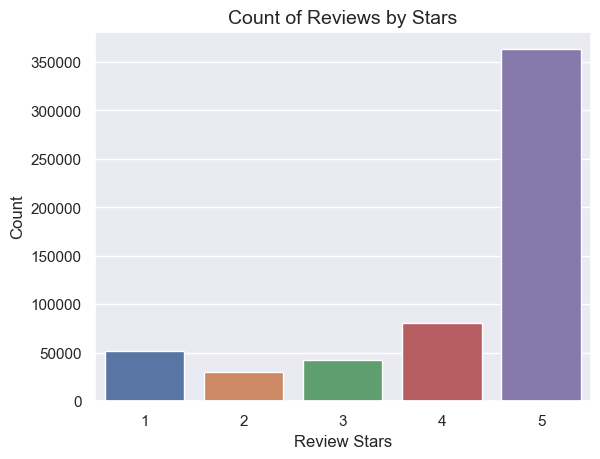

In [129]:
# Create a bar chart of the cleaned data for distribution
ax = sns.countplot(x=df['Score'])
ax.set_title('Distribution of Reviews by Stars', fontsize=14)
ax.set_xlabel('Review Stars', fontsize=12)
ax.set_ylabel('Count', fontsize=12)

plt.show()

### Example

In [130]:
example = df['Text'][44]
print(example)

We really like the McCann's steel cut oats but find we don't cook it up too often.<br />This tastes much better to me than the grocery store brands and is just as convenient.<br />Anything that keeps me eating oatmeal regularly is a good thing.


In [131]:
tokens = nltk.word_tokenize(example)
tokens[:15]

['We',
 'really',
 'like',
 'the',
 'McCann',
 "'s",
 'steel',
 'cut',
 'oats',
 'but',
 'find',
 'we',
 'do',
 "n't",
 'cook']

In [132]:
tagged = nltk.pos_tag(tokens)
tagged[:15]

[('We', 'PRP'),
 ('really', 'RB'),
 ('like', 'IN'),
 ('the', 'DT'),
 ('McCann', 'NNP'),
 ("'s", 'POS'),
 ('steel', 'NN'),
 ('cut', 'NN'),
 ('oats', 'NNS'),
 ('but', 'CC'),
 ('find', 'VBP'),
 ('we', 'PRP'),
 ('do', 'VBP'),
 ("n't", 'RB'),
 ('cook', 'VB')]

In [133]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  We/PRP
  really/RB
  like/IN
  the/DT
  (ORGANIZATION McCann/NNP)
  's/POS
  steel/NN
  cut/NN
  oats/NNS
  but/CC
  find/VBP
  we/PRP
  do/VBP
  n't/RB
  cook/VB
  it/PRP
  up/RP
  too/RB
  often./JJ
  </NNP
  br/NN
  //NNP
  >/NNP
  This/DT
  tastes/VBZ
  much/RB
  better/JJR
  to/TO
  me/PRP
  than/IN
  the/DT
  grocery/NN
  store/NN
  brands/NNS
  and/CC
  is/VBZ
  just/RB
  as/IN
  convenient./JJ
  </NNP
  br/NN
  //NNP
  >/NNP
  Anything/NNP
  that/WDT
  keeps/VBZ
  me/PRP
  eating/VBG
  oatmeal/JJ
  regularly/RB
  is/VBZ
  a/DT
  good/JJ
  thing/NN
  ./.)


# 1. VADER Analysis

In [144]:
# Initialize the SentimentIntensityAnalyzer object
sia = SentimentIntensityAnalyzer()

# Take an example to see the scores
sia.polarity_scores(example)

{'neg': 0.031, 'neu': 0.778, 'pos': 0.191, 'compound': 0.8421}

In [145]:
# Run the polarity score on the entire dataset and put the socres into a dictionary
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = str(row['Text'])
    id = row['Id']
    res[id] = sia.polarity_scores(text)

  0%|          | 0/568454 [00:00<?, ?it/s]

In [146]:
# Convert 'res' into a pandas DataFrame
vaders = pd.DataFrame(res).T
vaders.head()

,neg,neu,pos,compound
1,0.000,0.695,0.305,0.9441
2,0.138,0.862,0.000,-0.5664
3,0.091,0.754,0.155,0.8265
4,0.000,1.000,0.000,0.0000
5,0.000,0.552,0.448,0.9468


In [147]:
# Merge the vaders scores with original df
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders_merge = vaders.merge(df, how='left')

vaders_merge.head()

,Id,neg,neu,pos,compound,Score,Text
0,1,0.000,0.695,0.305,0.9441,5,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,1,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,4,This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,2,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,5,Great taffy at a great price. There was a wid...


c:\Users\Docky\Anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Docky\Anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Docky\Anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


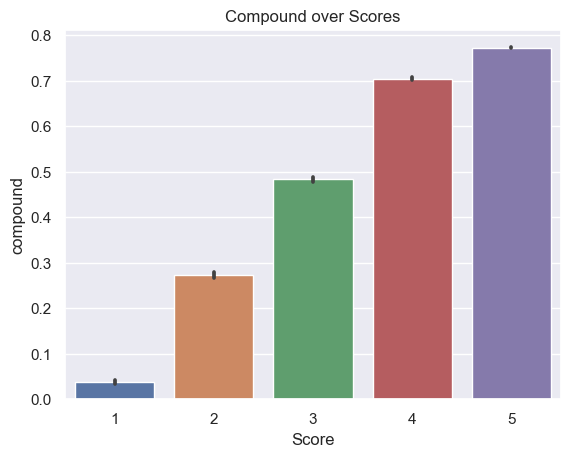

In [148]:
# Visualise the 'compound' sentiment scores aggregated for each 'Score' category in the 'vaders' DataFrame.
ax = sns.barplot(data=vaders_merge, x='Score', y='compound')

ax.set_title('Compound over Scores')

plt.show()

c:\Users\Docky\Anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Docky\Anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Docky\Anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Docky\Anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cat

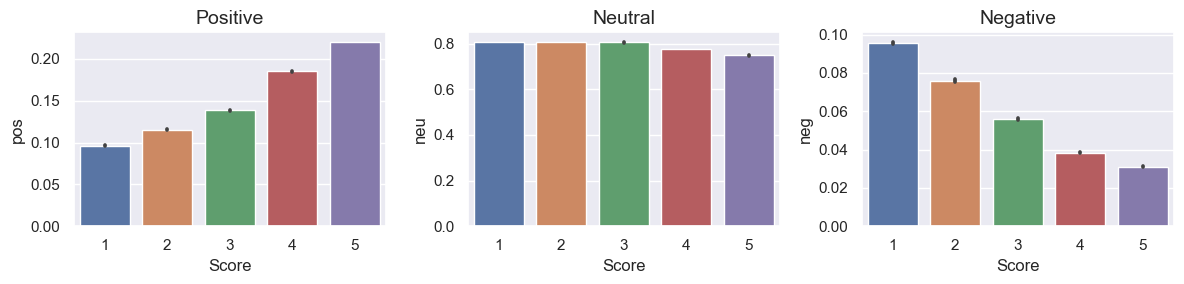

In [149]:
# Create a 1x3 subplot layout
fig, axs = plt.subplots(1, 3, figsize=(12, 3))

# Plot bar charts for positive, neutral, and negative sentiments
sns.barplot(data=vaders_merge, x='Score', y='pos', ax=axs[0])
sns.barplot(data=vaders_merge, x='Score', y='neu', ax=axs[1])
sns.barplot(data=vaders_merge, x='Score', y='neg', ax=axs[2])

# Set titles and font sizes for each subplot
axs[0].set_title('Positive', fontsize=14)
axs[1].set_title('Neutral', fontsize=14)
axs[2].set_title('Negative', fontsize=14)

plt.tight_layout()

plt.show()

# 2. TextBlob Analysis

In [150]:
TextBlob(example).sentiment

Sentiment(polarity=0.4666666666666666, subjectivity=0.43333333333333335)

In [151]:
sia.polarity_scores(example)

{'neg': 0.031, 'neu': 0.778, 'pos': 0.191, 'compound': 0.8421}

In [152]:
res = {}

# Run the sentiment analysis on the entire dataset and store the scores in 'res'
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = str(row['Text'])
    id = row['Id']
    analysis = TextBlob(text)
    res[id] = analysis.sentiment.polarity

  0%|          | 0/568454 [00:00<?, ?it/s]

In [153]:
# Convert 'res' into a pandas DataFrame
textblob_scores = pd.DataFrame.from_dict(res, orient='index', columns=['polarity'])

textblob_scores.head()

,polarity
1,0.450000
2,-0.033333
3,0.133571
4,0.166667
5,0.483333


In [154]:
# Merge the TextBlob scores with the vaders_merge
textblob_merge = textblob_scores.reset_index().rename(columns={'index': 'Id'})
textblob_merge = textblob_merge.merge(vaders_merge, how='left')

textblob_merge.head()

,Id,polarity,neg,neu,pos,compound,Score,Text
0,1,0.450000,0.000,0.695,0.305,0.9441,5,I have bought several of the Vitality canned d...
1,2,-0.033333,0.138,0.862,0.000,-0.5664,1,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.133571,0.091,0.754,0.155,0.8265,4,This is a confection that has been around a fe...
3,4,0.166667,0.000,1.000,0.000,0.0000,2,If you are looking for the secret ingredient i...
4,5,0.483333,0.000,0.552,0.448,0.9468,5,Great taffy at a great price. There was a wid...


c:\Users\Docky\Anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Docky\Anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Docky\Anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


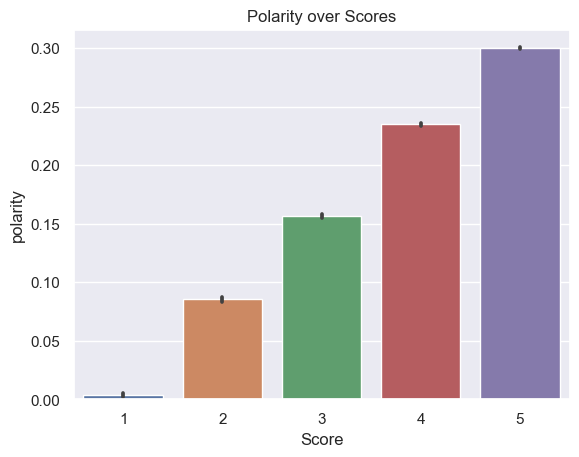

In [155]:
# Visualise the 'compound' sentiment scores aggregated for polarity in the 'textblob_merge' DataFrame.
ax = sns.barplot(data=textblob_merge, x='Score', y='polarity')

ax.set_title('Polarity over Scores')

plt.show()

In [156]:
# Transform the 'textblob_merge' DataFrame from wide format to long format.
long_format = pd.melt(textblob_merge, id_vars=['Score'], value_vars=['polarity', 'compound'], 
                      var_name='Type', value_name='Value')
long_format.head()

,Score,Type,Value
0,5,polarity,0.450000
1,1,polarity,-0.033333
2,4,polarity,0.133571
3,2,polarity,0.166667
4,5,polarity,0.483333


c:\Users\Docky\Anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Docky\Anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Docky\Anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Docky\Anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cat

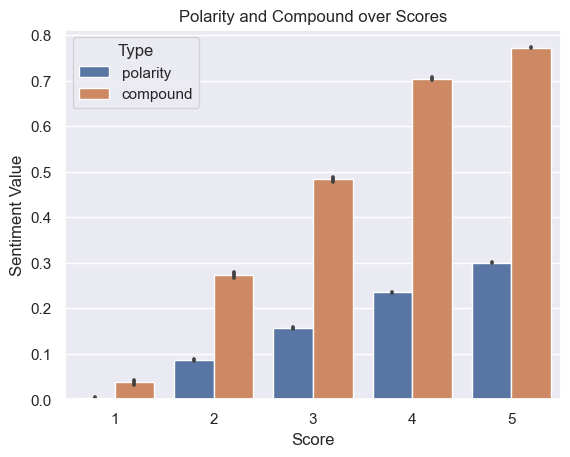

In [157]:
sns.barplot(data=long_format, x='Score', y='Value', hue='Type')

plt.title('Polarity and Compound over Scores')
plt.xlabel('Score')
plt.ylabel('Sentiment Value')
plt.show()

c:\Users\Docky\Anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Docky\Anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Docky\Anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Docky\Anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cat

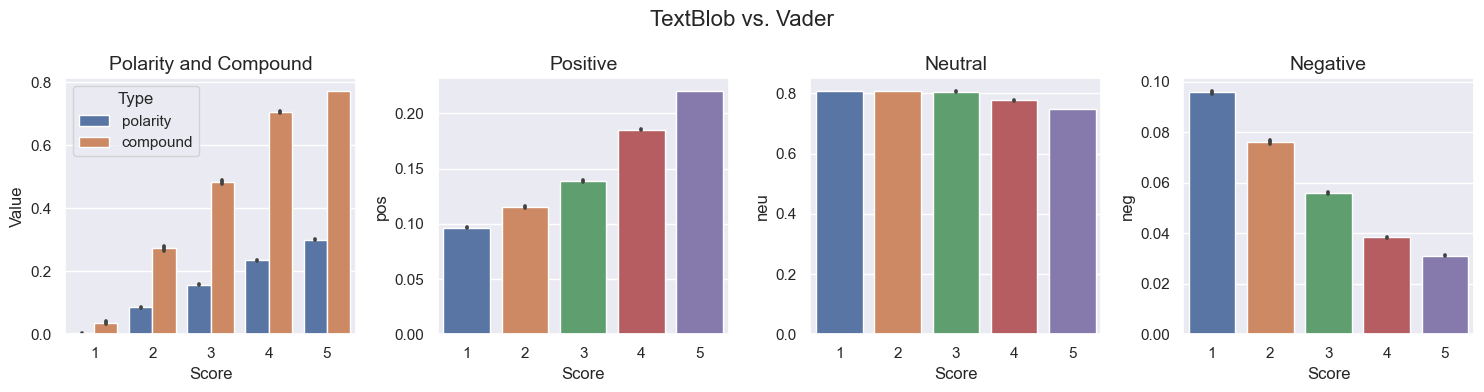

In [192]:
# Create a 1x4 subplot layout
fig, axs = plt.subplots(1, 4, figsize=(15, 4))

# Plot bar charts for positive, neutral, and negative sentiments
sns.barplot(data=long_format,  x='Score', y='Value', ax=axs[0], hue='Type')
sns.barplot(data=vaders_merge, x='Score', y='pos',   ax=axs[1])
sns.barplot(data=vaders_merge, x='Score', y='neu',   ax=axs[2])
sns.barplot(data=vaders_merge, x='Score', y='neg',   ax=axs[3])

# Set titles and font sizes for each subplot
axs[0].set_title('Polarity and Compound', fontsize=14)
axs[1].set_title('Positive', fontsize=14)
axs[2].set_title('Neutral', fontsize=14)
axs[3].set_title('Negative', fontsize=14)

# Set the overall (super) title for all subplots
fig.suptitle('TextBlob vs. Vader', fontsize=16, y=0.975)

plt.tight_layout()

plt.show()

# 3. Roberta Pretrained Model

In [159]:
# download the pretrained model
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [160]:
# Take an example to compare the score
example_score_rob = polarity_scores_roberta(example, tokenizer, model)
example_score_rob

{'roberta_neg': 0.005844251,
 'roberta_neu': 0.041151915,
 'roberta_pos': 0.9530039}

In [161]:
# Vadar socre for the example
sia.polarity_scores(example)

{'neg': 0.031, 'neu': 0.778, 'pos': 0.191, 'compound': 0.8421}

In [162]:
# TextBlob polarity for the example
TextBlob(example).sentiment

Sentiment(polarity=0.4666666666666666, subjectivity=0.43333333333333335)

In [200]:
# Run the twitter-roberta-base-sentiment model for entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        id = row['Id']
        roberta_result = polarity_scores_roberta(text, tokenizer, model)
        res[id] = roberta_result
    except RuntimeError:
        print(f'Break for id {id}')

  0%|          | 0/568454 [00:00<?, ?it/s]

In [174]:
rob_scores = pd.DataFrame(res).T
rob_merge = rob_scores.reset_index().rename(columns={'index': 'Id'})
rob_merge = rob_merge.merge(vaders_merge, how='left')

rob_merge.rename(columns={
        'neg': 'vader_neg',
        'neu': 'vader_neu',
        'pos': 'vader_pos'
}, inplace=True)

In [175]:
rob_merge.head()

,Id,roberta_neg,roberta_neu,roberta_pos,vader_neg,vader_neu,vader_pos,compound,Score,Text
0,1,0.009624,0.049980,0.940395,0.000,0.695,0.305,0.9441,5,I have bought several of the Vitality canned d...
1,2,0.508986,0.452414,0.038600,0.138,0.862,0.000,-0.5664,1,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.003229,0.098067,0.898704,0.091,0.754,0.155,0.8265,4,This is a confection that has been around a fe...
3,4,0.002295,0.090219,0.907486,0.000,1.000,0.000,0.0000,2,If you are looking for the secret ingredient i...
4,5,0.001635,0.010302,0.988063,0.000,0.552,0.448,0.9468,5,Great taffy at a great price. There was a wid...


In [4]:
rob_merge = pd.read_csv("rob_merge.csv")
rob_merge.head()

,Id,roberta_neg,roberta_neu,roberta_pos,vader_neg,vader_neu,vader_pos,compound,Score,Text
0,1,0.009624,0.049980,0.940395,0.000,0.695,0.305,0.9441,5,I have bought several of the Vitality canned d...
1,2,0.508986,0.452414,0.038600,0.138,0.862,0.000,-0.5664,1,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.003229,0.098067,0.898704,0.091,0.754,0.155,0.8265,4,This is a confection that has been around a fe...
3,4,0.002295,0.090219,0.907486,0.000,1.000,0.000,0.0000,2,If you are looking for the secret ingredient i...
4,5,0.001635,0.010302,0.988063,0.000,0.552,0.448,0.9468,5,Great taffy at a great price. There was a wid...


In [5]:
# Calculate the polarity for each text

# Multiplying each probability to its weights (-1=> negative, 0=>neutral and +1=>positive)
polarity_weights = torch.tensor([-1, 0, 1])
probs = torch.tensor(rob_merge[["roberta_neg", "roberta_neu", "roberta_pos"]].values)
polarity = polarity_weights * probs

# Sum the values and pass through Tanh function to scale values from -1 up to +1
polarity = polarity.sum(dim=-1)
polarity_scaled = nn.Tanh()(polarity)

rob_merge["roberta_polarity"] = polarity_scaled.numpy()

In [6]:
rob_merge.head()

,Id,roberta_neg,roberta_neu,roberta_pos,vader_neg,vader_neu,vader_pos,compound,Score,Text,roberta_polarity
0,1,0.009624,0.049980,0.940395,0.000,0.695,0.305,0.9441,5,I have bought several of the Vitality canned d...,0.730953
1,2,0.508986,0.452414,0.038600,0.138,0.862,0.000,-0.5664,1,Product arrived labeled as Jumbo Salted Peanut...,-0.438511
2,3,0.003229,0.098067,0.898704,0.091,0.754,0.155,0.8265,4,This is a confection that has been around a fe...,0.714087
3,4,0.002295,0.090219,0.907486,0.000,1.000,0.000,0.0000,2,If you are looking for the secret ingredient i...,0.718816
4,5,0.001635,0.010302,0.988063,0.000,0.552,0.448,0.9468,5,Great taffy at a great price. There was a wid...,0.755835


c:\Users\Docky\Anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Docky\Anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Docky\Anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Docky\Anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cat

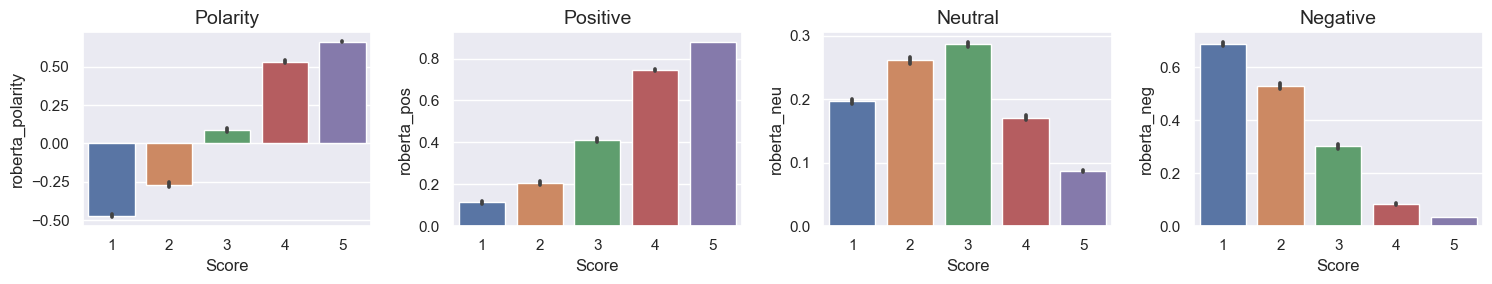

In [12]:
# Create a 1x3 subplot layout
fig, axs = plt.subplots(1, 4, figsize=(15, 3))

# Plot bar charts for positive, neutral, and negative sentiments
sns.barplot(data=rob_merge, x='Score', y='roberta_polarity', ax=axs[0])
sns.barplot(data=rob_merge, x='Score', y='roberta_pos',      ax=axs[1])
sns.barplot(data=rob_merge, x='Score', y='roberta_neu',      ax=axs[2])
sns.barplot(data=rob_merge, x='Score', y='roberta_neg',      ax=axs[3])

# Set titles and font sizes for each subplot
axs[0].set_title('Polarity', fontsize=14)
axs[1].set_title('Positive', fontsize=14)
axs[2].set_title('Neutral', fontsize=14)
axs[3].set_title('Negative', fontsize=14)

plt.tight_layout()

plt.show()

c:\Users\Docky\Anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Docky\Anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Docky\Anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


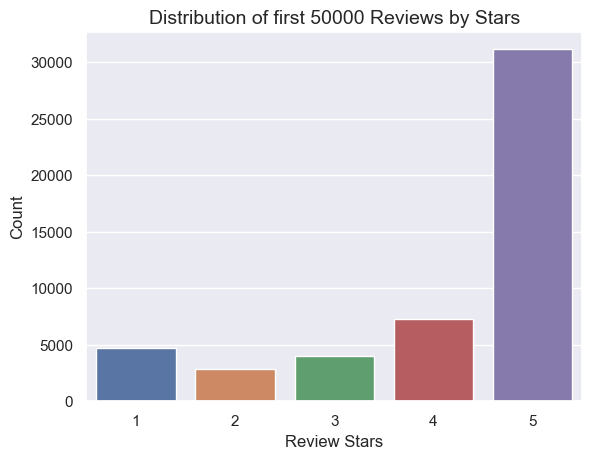

In [198]:
# Create a bar chart of the cleaned data for distribution
ax = sns.countplot(x=rob_merge['Score'])
ax.set_title('Distribution of first 50000 Reviews by Stars', fontsize=14)
ax.set_xlabel('Review Stars', fontsize=12)
ax.set_ylabel('Count', fontsize=12)

plt.show()

# the plot shows that the distribution is very similar to the entire dataset, so it is still representative as the entire one.

c:\Users\Docky\Anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Docky\Anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Docky\Anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Docky\Anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cat

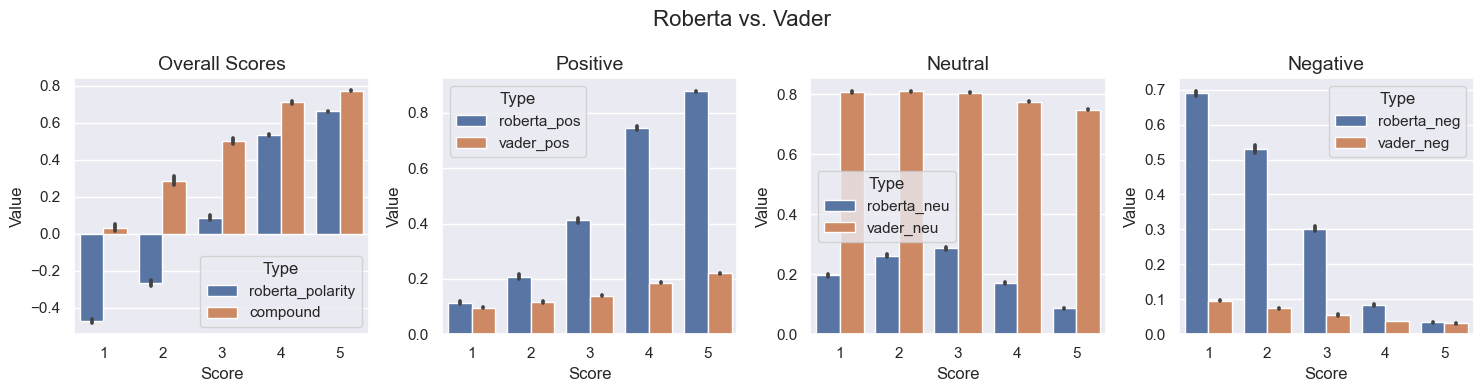

In [10]:
# Transform the 'rob_merge' DataFrame from wide format to long format for each sentiment
long_format_com = pd.melt(rob_merge, id_vars=['Score'], value_vars=['roberta_polarity', 'compound'], 
                      var_name='Type', value_name='Value')

long_format_pos = pd.melt(rob_merge, id_vars=['Score'], value_vars=['roberta_pos', 'vader_pos'], 
                        var_name='Type', value_name='Value')

long_format_neu = pd.melt(rob_merge, id_vars=['Score'], value_vars=['roberta_neu', 'vader_neu'], 
                        var_name='Type', value_name='Value')

long_format_neg = pd.melt(rob_merge, id_vars=['Score'], value_vars=['roberta_neg', 'vader_neg'], 
                        var_name='Type', value_name='Value')

# Create a 1x3 subplot layout
fig, axs = plt.subplots(1, 4, figsize=(15, 4))

# Plot bar charts for positive, neutral, and negative sentiments
sns.barplot(data=long_format_com, x='Score', y='Value', hue='Type', ax=axs[0])
sns.barplot(data=long_format_pos, x='Score', y='Value', hue='Type', ax=axs[1])
sns.barplot(data=long_format_neu, x='Score', y='Value', hue='Type', ax=axs[2])
sns.barplot(data=long_format_neg, x='Score', y='Value', hue='Type', ax=axs[3])

# Set titles and font sizes for each subplot
axs[0].set_title('Overall Scores', fontsize=14)
axs[1].set_title('Positive', fontsize=14)
axs[2].set_title('Neutral', fontsize=14)
axs[3].set_title('Negative', fontsize=14)

# Set the overall (super) title for all subplots
fig.suptitle('Roberta vs. Vader', fontsize=16, y=0.975)

plt.tight_layout()

plt.show()

# 4. Comparison

c:\Users\Docky\Anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Docky\Anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Docky\Anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Docky\Anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cat

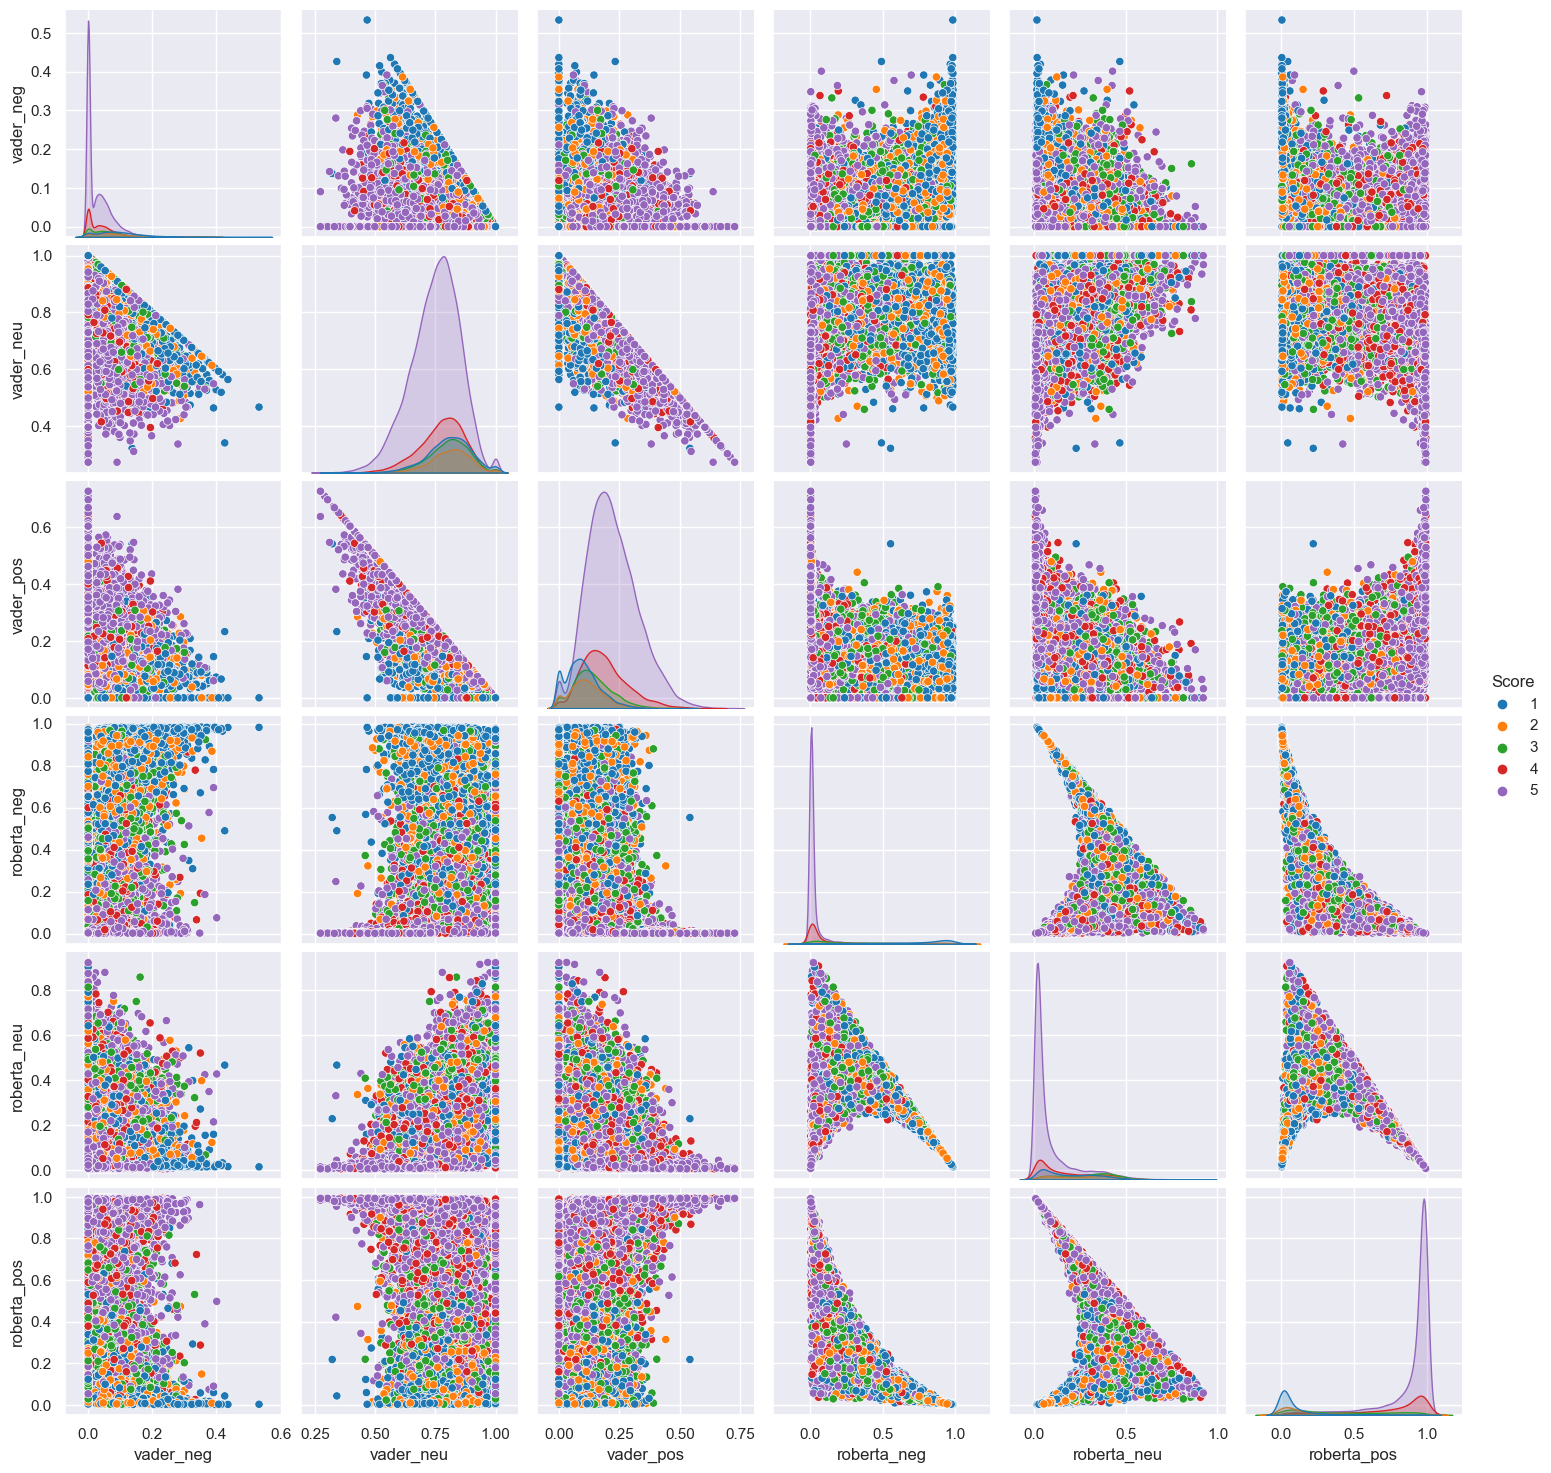

In [193]:
# Create a pairplot to visualize pairwise relationships in the dataset.
sns.pairplot(data=rob_merge,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='Score',
            palette='tab10')
plt.show()